In [1]:
# !pip install grad-cam

In [2]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os
import warnings

from pathlib import Path

from timm.data import Mixup
from timm.models import create_model
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict


import models
import utils
import sys
import cv2
from datasetsV2 import get_transform_to_eval, get_transform_to_eval_filter3, get_transform_to_eval_NO_SRM, get_transform_to_eval_Sobel
from torchvision.transforms import ToPILImage

from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import pandas as pd
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,  log_loss
import math

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.0 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [3]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'

In [4]:
def preprocess_image_transform(image_path, transform):
    image = Image.open(image_path).convert('RGB').resize((224, 224))
    image = np.array(image)
    augmented = transform(image=image)
    return augmented['image'].squeeze(0)

In [5]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [6]:
def get_transform(logs_path):
    if 'baseline' in logs_path:
        print("using without srm")
        return get_transform_to_eval_NO_SRM(224)
    elif "input" in logs_path and "srm" in logs_path:
        print("using input srm")
        return get_transform_to_eval(224)
    elif "input" in logs_path and "sobel" in logs_path:
        print("using input sobel")
        return get_transform_to_eval_Sobel(224)
    elif "branch" in logs_path and "srm" in logs_path:
        print("using branch filter")
        return get_transform_to_eval_NO_SRM(224)
    elif "branch" in logs_path and "sobel" in logs_path:
        print("using branch filter")
        return get_transform_to_eval_NO_SRM(224)
    else:
        return get_transform_to_eval_NO_SRM(224) 

In [7]:
result_dict = {}
prob_dict = {}
df_global = []

In [8]:
def detect_deepfake(imgs_paths, video_name, count_thresh, n_images, transform, model):
    count_fake = 0
    count_real = 0
    # for img in imgs_paths:
    if n_images <= len(imgs_paths):
        imgs_paths = random.sample(imgs_paths, n_images)

    input_tensor = [preprocess_image_transform(x, transform) for x in imgs_paths]
    input_tensor = torch.stack((input_tensor))

    # print(input_tensor.shape)
    # for img in input_tensor:
    img = input_tensor.to(device)
    results = model(img)
    pred = torch.sigmoid(results)
    # print(pred)
    pred = pred.to('cpu')
    for result in pred:
        detected = "FAKE" if result.item() > 0.5 else "REAL"
        if detected == "FAKE":
            count_fake += 1
        else:
            count_real += 1

    video_name = video_name.split("/")[-1]
    # print(video_name)
    if count_fake > count_real:
        
        result_dict[video_name] = 1
        # print("FAKE")
    else:
        result_dict[video_name] = 0
        # print("REAL")
    
    # Calculando a média das predições e armazenando no dicionário
    pred_mean = np.mean(pred.detach().numpy().tolist())
    prob_dict[video_name] = pred_mean

In [9]:
# def get_transform(path):
#     if "transform" in path and "srm" in path:
#         print("SRM TRANSFORM")
#         return get_transform_to_eval(224)
#     elif "transform" in path and "sobel" in path:
#         print("SOBEL TRANSFORM")
#         return get_transform_to_eval_Sobel(224)
#     else:
#         print("L_BRANCH")
#     # version = int(version)
#     # if version == 10 or version == '18_baseline_0_5':
#     #     print("using get_transform_to_eval_NO_SRM")
#         return get_transform_to_eval_NO_SRM(224)
#     # elif version == 12 or '16_new_srm':
#     #     print("using get_transform_to_eval")
#     #     return get_transform_to_eval(224)
#     # elif version == '17_sobel_0_5':
#     #     print("using get_transform_to_eval_Sobel")
#     #     return get_transform_to_eval_Sobel(224)
#     # if version == '14_no_srm' or version == '18_baseline_0_5':
#     #     print("using get_transform_to_eval_NO_SRM")
#     #     return get_transform_to_eval_NO_SRM(224)
#     # else:
#     #     print("using get_transform_to_eval_filter3")
#     #     return get_transform_to_eval_filter3(224)

# get_transform('/home/eferreira/master/cross-vit/CrossViT/old_logs/7')

In [10]:
def make_predictions(logs_path, technic):
    backbone = ''
    args = open(os.path.join(logs_path, 'args.txt'),'r')
    for txt in args:
        if "model" in txt:
            print(txt)
            backbone = txt.split(' ')[-1][:-1]

    model = create_model(
    backbone,
    pretrained=True,
    num_classes=1
)
    model_path = os.path.join(logs_path, 'model_best.pth')
    checkpoint = torch.load(model_path, map_location='cpu')
    utils.load_checkpoint(model, checkpoint['model'])
    model.eval()
    
    transform = get_transform(logs_path)
    model.to(device)

    basedir = f'/home/eferreira/master/storage/ff++/ff++/test/manipulated_sequences/{technic}'

    videos = os.listdir(basedir)
    filenames = [x for x in videos]
    labels_df = [[x, 1] for x in filenames]

    original_seq_base_dir = "/home/eferreira/master/storage/ff++/ff++/test/original_sequences"
    original_videos = os.listdir(original_seq_base_dir)
    actors_filenames = [[x, 0] for x in original_videos]
    labels_df.extend(actors_filenames)
    labels_df = pd.DataFrame(labels_df, columns=['filename', 'label'])

    all_videos = os.listdir(basedir)
    all_videos = [os.path.join(basedir, x) for x in all_videos]

    original_faces_path = original_seq_base_dir
    original_faces = os.listdir(original_faces_path)
    original_faces = [os.path.join(original_faces_path, x) for x in original_faces]
    all_videos.extend(original_faces)

    # print(labels_df)
    

    for video in tqdm(all_videos):
    # print(video)
        # parent_name = os.path.join(basedir, video)
        # print(parent_name)
        imgs = os.listdir(video)
        imgs = [os.path.join(video, x) for x in imgs]
        # print(imgs)
        detect_deepfake(imgs, video, 18, 30,transform, model)
    
    save_dir = logs_path
    
    results_json_path = os.path.join(save_dir, f'results_{technic}.json')
    print("saving to: ", results_json_path)
    with open(results_json_path, "w") as outfile: 
        json.dump(result_dict, outfile)

    results_prob_json_path = os.path.join(save_dir, f'results_prob_{technic}.json')
    print("saving to: ", results_prob_json_path)
    with open(results_prob_json_path, "w") as outfile: 
        json.dump(prob_dict, outfile)
    
    df = labels_df.copy()
    # print(df)
    # df.columns = ['label', 'filename']
    # df['id'] = df['filename'].apply(lambda x: x[:-4])
    df['filename'] = df['filename'].map(lambda x: x)
    df = df.sort_values(by='filename')
    df_filtered = df[df['filename'].isin(result_dict.keys())]
    df_filtered['prediction'] = df_filtered['filename'].map(result_dict)    
    df_filtered['prediction_prob'] = df_filtered['filename'].map(prob_dict) 

    # Calculando as métricas
    # print(df_filtered['filename'], result_dict)

    y_true = df_filtered['label']
    y_pred = df_filtered['prediction']
    y_pred_prob = df_filtered['prediction_prob']

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    logloss = log_loss(y_true, y_pred_prob)

    # Exibindo as métricas
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Log Loss: {logloss:.2f}")

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Logloss'],
    'Value': [accuracy, precision, recall, f1, roc_auc, logloss]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_path = os.path.join(save_dir, f'metrics_{technic}.csv')
    metrics_df.to_csv(os.path.join(save_dir, f'metrics_{technic}.csv'), index=False)

        # Plotando e salvando o gráfico da curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(save_dir, f'roc_curve_{technic}_new.png'))
    plt.show()


In [11]:
result_dict

{}

In [12]:
df_global

[]

In [13]:
log_path = [
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/12_srm_input_transform',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/17_sobel_input_transform',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/18_baseline_0_5',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/24_srm_l_branch_simple',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/28_sobel_l_branch',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/30_srm_l_branch',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/31_srm_s_branch',
    # '/home/eferreira/master/cross-vit/CrossViT/old_logs/32_sobel_s_branch'
    '/home/eferreira/master/cross-vit/CrossViT/logs'
            ]
            
# log_path = ['/home/eferreira/master/cross-vit/CrossViT/old_logs/12']

In [14]:
# technic = 'DeepFakeDetection'
# basedir = f'/home/eferreira/master/storage/ff++/ff++/manipulated_sequences/{technic}/raw/videos'
# source_dir = os.path.join(basedir, "faces")

# videos = os.listdir(basedir)
# filenames = [x[:-4] for x in videos if 'mp4' in x]
# labels_df = [[x, 1] for x in filenames]
# original_seq_base_dir = "/home/eferreira/master/storage/ff++/ff++/original_sequences"
# original_actors = os.path.join(original_seq_base_dir, "actors/raw/videos")

# original_youtube = os.path.join(original_seq_base_dir, "youtube/raw/videos")
# actors_videos = os.listdir(original_actors)
# youtube_videos = os.listdir(original_youtube)
# actors_filenames = [[x[:-4], 0] for x in actors_videos if 'mp4' in x]
# youtube_filenames = [[x[:-4], 0] for x in youtube_videos if 'mp4' in x]
# labels_df.extend(actors_filenames)
# labels_df.extend(youtube_filenames)

NeuralTextures
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmps42yif2k ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_NeuralTextures.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_NeuralTextures.json
Accuracy: 0.59
Precision: 0.62
Recall: 0.50
F1 Score: 0.55
Log Loss: 1.13


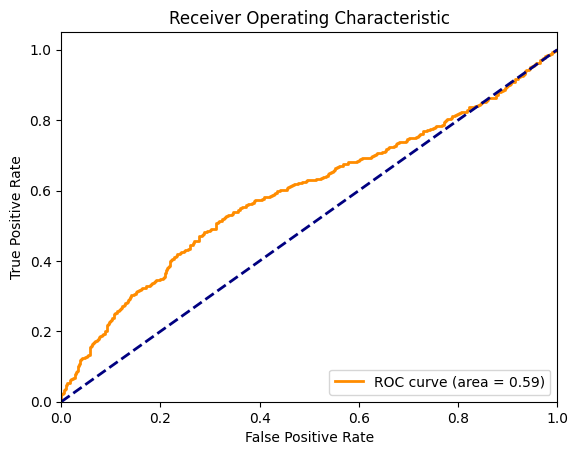

Deepfakes
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmp_y6r8xfl ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_Deepfakes.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_Deepfakes.json
Accuracy: 0.71
Precision: 0.70
Recall: 0.74
F1 Score: 0.72
Log Loss: 0.71


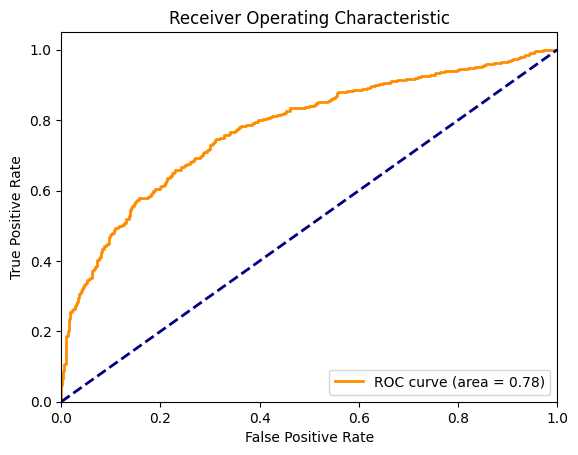

DeepFakeDetection
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmpk6y88o1d ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_DeepFakeDetection.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_DeepFakeDetection.json
Accuracy: 0.71
Precision: 0.70
Recall: 0.74
F1 Score: 0.72
Log Loss: 0.65


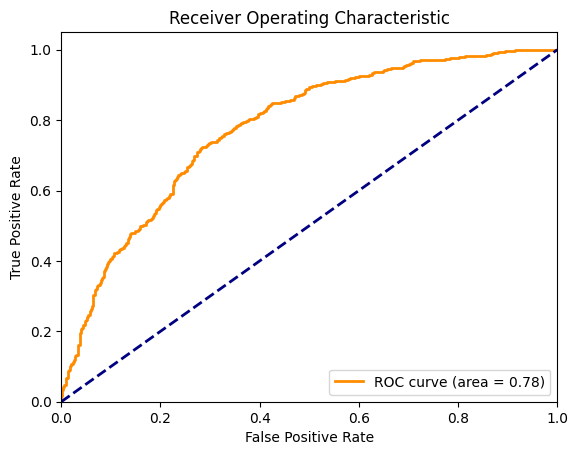

FaceSwap
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmp3nv_a2am ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_FaceSwap.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_FaceSwap.json
Accuracy: 0.72
Precision: 0.71
Recall: 0.77
F1 Score: 0.73
Log Loss: 0.68


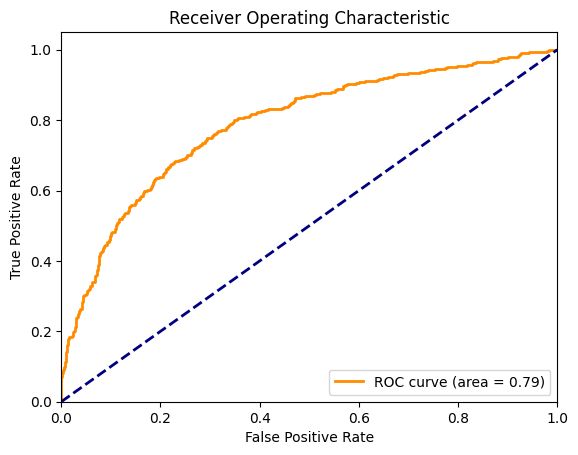

FaceShifter
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmpx5bryjrt ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_FaceShifter.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_FaceShifter.json
Accuracy: 0.55
Precision: 0.57
Recall: 0.43
F1 Score: 0.49
Log Loss: 1.10


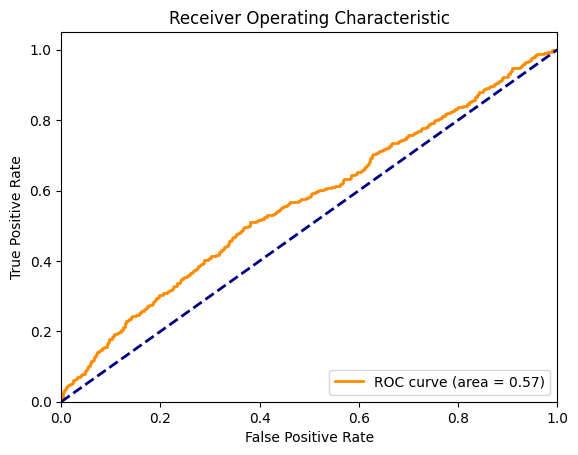

Face2Face
model: crossvit_18_dagger_224_srm_L_sobel_S

ViT with 1 classes.


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /tmp/tmpn4rldqlb ...


  0%|          | 0/1400 [00:00<?, ?it/s]

saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_Face2Face.json
saving to:  /home/eferreira/master/cross-vit/CrossViT/logs/results_prob_Face2Face.json
Accuracy: 0.59
Precision: 0.61
Recall: 0.49
F1 Score: 0.54
Log Loss: 1.14


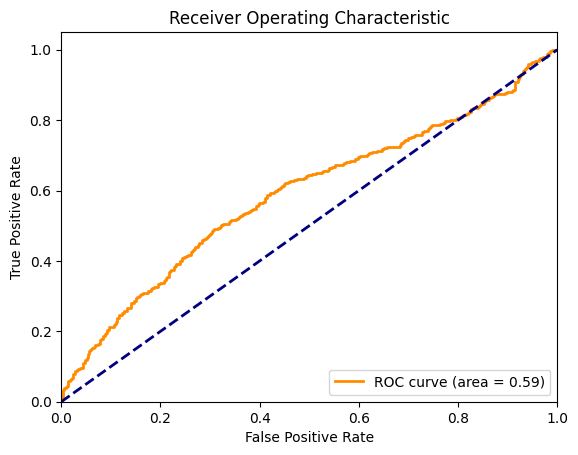

In [15]:
for path in log_path:
    
    for technic in os.listdir('/home/eferreira/master/storage/ff++/ff++/manipulated_sequences'):
        print(technic)
        make_predictions(path, technic)